# Improvement: Optimization

### **Preparation**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets
from opt_utils import *
from testCases_opt import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### 1. **The OG: Gradient Descent**

In [2]:
def update_parameters_with_gd(params, grads, learning_rate):
    for l in range(len(params) // 2):
        params["W" + str(l+1)] -= learning_rate * grads['dW'+str(l+1)]
        params["b" + str(l+1)] -= learning_rate * grads['db'+str(l+1)]
    return params

In [3]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()
parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


- **(Batch) Gradient Descent**:

``` python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    a, caches = forward_propagation(X, parameters)
    cost = compute_cost(a, Y)
    grads = backward_propagation(a, caches, parameters)
    parameters = update_parameters(parameters, grads)
        
```

- **Stochastic Gradient Descent**:

```python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    for j in range(0, m):
        a, caches = forward_propagation(X[:,j], parameters)
        cost = compute_cost(a, Y[:,j])
        grads = backward_propagation(a, caches, parameters)
        parameters = update_parameters(parameters, grads)
```

**Note**: implementing SGD requires 3 for-loops in total:
1. Over the number of iterations
2. Over the $m$ training examples
3. Over the layers (to update all parameters, from $(W^{[1]},b^{[1]})$ to $(W^{[L]},b^{[L]})$)

<br>**Lessons**:
- The difference between gradient descent, mini-batch gradient descent and stochastic gradient descent is #examples you use to perform one update step.
- You have to tune the learning rate $\alpha$.
- With a well-turned mini-batch size, usually it outperforms either gradient descent or stochastic gradient descent (particularly when the training set is large).

### 2. **Mini-Batch GD**

In [4]:
def random_mini_batches(X,Y,mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    # Step 1: Shuffle (X,Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation].reshape((1,m))
    
    # Step 2: Partition
    n_complete_mbs = math.floor(m/mini_batch_size)
    for k in range(0,n_complete_mbs):
        mb_X = shuffled_X[:,mini_batch_size*k:mini_batch_size*(k+1)]
        mb_Y = shuffled_Y[:,mini_batch_size*k:mini_batch_size*(k+1)]
        mb = (mb_X,mb_Y)
        mini_batches.append(mb)
        
    # Step 3: The end case (last_mb_size < mb_size)
    if m%mini_batch_size != 0:
        mb_X = shuffled_X[:,mini_batch_size*n_complete_mbs:m]
        mb_Y = shuffled_Y[:,mini_batch_size*n_complete_mbs:m]
        mb = (mb_X,mb_Y)
        mini_batches.append(mb)
    return mini_batches

In [5]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)
print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


**Lessons**:
- **Shuffling and Partitioning** are the two steps required to build mini-batches
- Powers of two are often chosen to be the mini-batch size, e.g., 16, 32, 64, 128.

### 3. **Momentum**

for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where
- L: #layers
- $\beta$: momentum
- $\alpha$: learning rate.

In [6]:
def initialize_velocity(params):
    v = {}
    for l in range(len(params) // 2):
        v["dW" + str(l+1)] = np.zeros(params["W"+str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(params["b"+str(l+1)].shape)
    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    for l in range(len(parameters) // 2):
        v["dW"+str(l+1)] = beta*v["dW"+str(l+1)]+(1-beta)*grads["dW"+str(l+1)]
        v["db"+str(l+1)] = beta*v["db"+str(l+1)]+(1-beta)*grads["db"+str(l+1)]
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)]-learning_rate*grads["db"+str(l+1)]
    return parameters, v

In [7]:
parameters, grads, v = update_parameters_with_momentum_test_case()
parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


**Note**:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account.
- If $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$. 

**Lessons**:
- Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
- You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.

### 4. **Adam**

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

<br>for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t: #steps taken of Adam
- $\beta_1$ & $\beta_2$: hyperparameters that control the two exponentially weighted averages. 
- $\varepsilon$: avoid dividing by zero

In [8]:
def initialize_adam(parameters) :
    v = {}
    s = {}
    for l in range(len(parameters) // 2):
        v["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        v["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        s["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        s["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    v_corrected = {}
    s_corrected = {}
    for l in range(len(parameters) // 2):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW"+str(l+1)] = beta1*v["dW"+str(l+1)]+(1-beta1)*grads["dW"+str(l+1)]
        v["db"+str(l+1)] = beta1*v["db"+str(l+1)]+(1-beta1)*grads["db"+str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW"+str(l+1)] = v["dW"+str(l+1)]/(1-np.power(beta1,t))
        v_corrected["db"+str(l+1)] = v["db"+str(l+1)]/(1-np.power(beta1,t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW"+str(l+1)] = beta2*s["dW"+str(l+1)]+(1-beta2)*np.power(grads["dW"+str(l+1)],2)
        s["db"+str(l+1)] = beta2*s["db"+str(l+1)]+(1-beta2)*np.power(grads["db"+str(l+1)],2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW"+str(l+1)] = s["dW"+str(l+1)]/(1-np.power(beta2,t))
        s_corrected["db"+str(l+1)] = s["db"+str(l+1)]/(1-np.power(beta2,t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)]-learning_rate*v_corrected["dW"+str(l+1)]/(np.sqrt(s_corrected["dW"+str(l+1)])+epsilon)
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)]-learning_rate*v_corrected["db"+str(l+1)]/(np.sqrt(s_corrected["db"+str(l+1)])+epsilon)
    return parameters, v, s

In [9]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09244991 -0.16498684]]
b2 = [[-0.88529979]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = [[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


### Model with different optimization algorithms

- Mini-batch **Gradient Descent**
- Mini-batch **Momentum**
- Mini-batch **Adam**

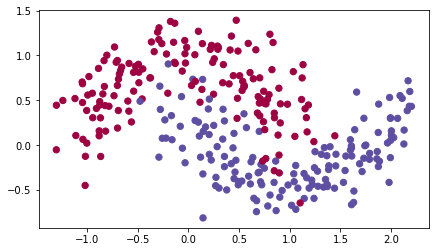

In [10]:
train_X, train_Y = load_dataset()

In [11]:
def model(X,Y,layers_dims,optimizer,learning_rate=0.0007,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=10000,print_cost=True):
    # Set consts
    L = len(layers_dims)
    costs = []
    t = 0
    seed = 10
    
    # Initialization
    params = initialize_parameters(layers_dims)
    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(params)
    elif optimizer == "adam":
        v,s = initialize_adam(params)
    
    # Optimization
    for i in range(num_epochs):
        seed += 1
        mbs = random_mini_batches(X,Y,mini_batch_size,seed)
        for mb in mbs:
            (mb_X,mb_Y) = mb
            a3, caches = forward_propagation(mb_X, params)
            cost = compute_cost(a3, mb_Y)
            grads = backward_propagation(mb_X,mb_Y,caches)
            
            if optimizer == "gd":
                params = update_parameters_with_gd(params,grads,learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(params,grads,v,beta,learning_rate)
            elif optimizer == "adam":
                t += 1
                parameters, v, s = update_parameters_with_adam(params,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
        
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    return params

### Model 1: MBGD

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


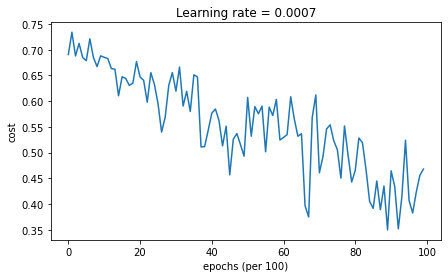

Accuracy: 0.7966666666666666


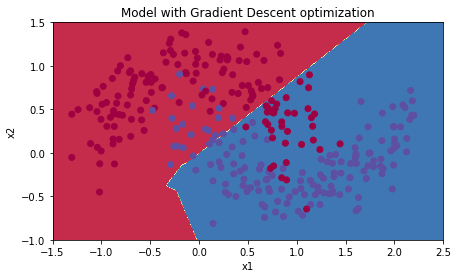

In [12]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd")
predictions = predict(train_X, train_Y, parameters)
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Model 2: MBGD with Momentum

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


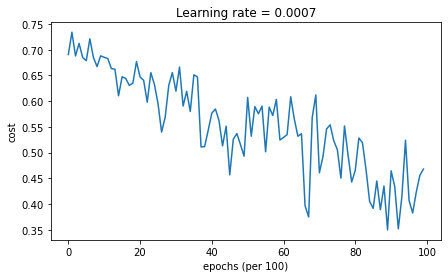

Accuracy: 0.7966666666666666


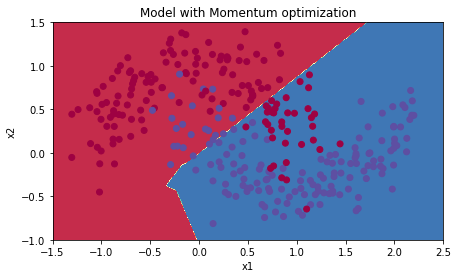

In [13]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta=0.9, optimizer="momentum")
predictions = predict(train_X, train_Y, parameters)
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Model 3: MBGD with Adam

Cost after epoch 0: 0.690552
Cost after epoch 1000: 0.185567
Cost after epoch 2000: 0.150852
Cost after epoch 3000: 0.074454
Cost after epoch 4000: 0.125936
Cost after epoch 5000: 0.104235
Cost after epoch 6000: 0.100552
Cost after epoch 7000: 0.031601
Cost after epoch 8000: 0.111709
Cost after epoch 9000: 0.197648


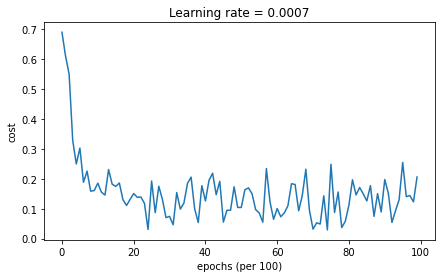

Accuracy: 0.94


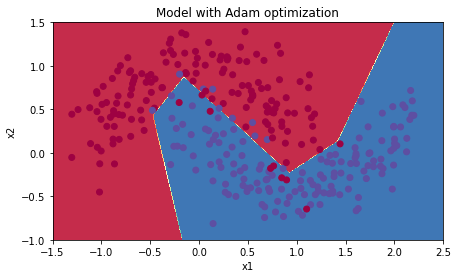

In [14]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="adam")
predictions = predict(train_X, train_Y, parameters)
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

| GD | Momentum | Adam |
|:-----:|:---------:|:--------:|
| 80% | 80% | 94% |
| oscillations | oscillations | smoother |

<br>**Advantages of Adam**:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)